In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import gymnasium as gym
from custom_envs import RandomWalker1D
from custom_agents import AgentGrad
from scipy.ndimage import gaussian_filter1d

In [151]:
class ShortCorridorGridworld():
    def __init__(self):
        self.state = 0
        self.a_right = torch.tensor([1, 0], dtype=torch.float).reshape(2, 1)
        self.a_left = torch.tensor([0, 1], dtype=torch.float).reshape(2, 1)

    def step(self, a):
        if (a > 1) or (a < 0):
            raise ValueError('a can only be integer 0 or 1.')
        r = -1
        terminated = False
        new_state = self.state
        if self.state == 0:
            if a == 0:  # right
                new_state += 1
        elif self.state == 1:  # Reverse action
            if a == 0:  # a=right, becomes left
                new_state -= 1
            elif a == 1:  # a=left, becomes right
                new_state += 1
        elif self.state == 2:
            if a ==0:
                new_state += 1
            elif a == 1:
                new_state -= 1
        elif self.state == 3:  # Terminal state
            if a == 1:
                new_state -= 1
        else:
            raise ValueError('Action based on undefined state.')
        if new_state == 3:
            terminated = True
        self.state = new_state
        
        return self.state, r, terminated
    
    def reset(self):
        self.state = 0
        return self.state
    
            


    

In [208]:
a_probs_np

array([0.5359576 , 0.46404243], dtype=float32)

In [227]:
# Monte-carlo
Q_model = torch.nn.Sequential(
    nn.Linear(2, 1), # 0
    nn.Softmax(dim=0)
)
torch.nn.init.normal_(Q_model[0].weight, 0, 1e-5)

env = ShortCorridorGridworld()
amat = torch.eye(2, dtype=torch.float, requires_grad=False)
gamma = 1
alpha = 2 ** (-14)
Niters = 20000
all_totalt = np.zeros(Niters)
all_totalG = np.zeros(Niters)

for ni in range(Niters):
    if (ni % 1000 == 0):
        print(ni, t, a_probs_np)

    env.reset()
    Q_model.zero_grad()
    terminated = False
    all_t = []
    all_a = []
    all_R = []
    t = 0

    with torch.no_grad():
        a_probs = Q_model(amat)
    a_probs_np = a_probs.detach().numpy().squeeze()

    while terminated is False:
        a = np.random.choice([0, 1], p=a_probs_np)
        _, r, terminated = env.step(a)
        all_t.append(t)
        all_a.append(a)
        all_R.append(r)
        t += 1

    L = len(all_t)
    for k in range(L):
        ep_t = all_t[k]
        ep_a = all_a[k]
        ep_r = all_R[k]
        
        
        G_t = np.sum([ all_R[j] * (gamma ** (j-k))  for j in range(k, L)])

        if k ==0:
            all_totalG[ni] = G_t
        

        a_probs = Q_model(amat)
        log_aprob_this = torch.log(a_probs[ep_a])
        log_aprob_this.backward()
        with torch.no_grad():
            Q_model[0].weight += alpha * (gamma ** ep_t) * G_t * Q_model[0].weight.grad
        Q_model.zero_grad()


    all_totalt[ni] = all_t[-1]



0 7 [0.6112726  0.38872743]
1000 3 [0.5357753  0.46422476]
2000 6 [0.5890673  0.41093272]
3000 28 [0.57953244 0.4204676 ]
4000 11 [0.57675594 0.42324403]
5000 19 [0.5911505 0.4088495]
6000 37 [0.59038556 0.4096144 ]
7000 9 [0.6069524  0.39304754]
8000 5 [0.59014076 0.40985918]
9000 20 [0.5711013  0.42889872]
10000 11 [0.60690725 0.39309278]
11000 16 [0.5834336  0.41656637]
12000 9 [0.5701627 0.4298373]
13000 32 [0.58293074 0.4170692 ]
14000 6 [0.5897112 0.4102888]
15000 25 [0.6012538  0.39874616]
16000 4 [0.5776334  0.42236662]
17000 14 [0.59134513 0.4086549 ]
18000 15 [0.6265378  0.37346223]
19000 9 [0.62385863 0.3761413 ]


Text(0.5, 1.0, 'aver_G(sigma1000) at 15000 = -11.6203')

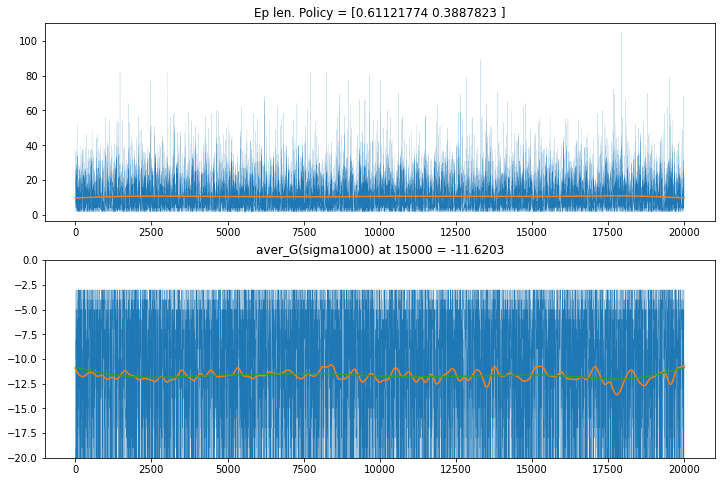

In [228]:
aver_t = gaussian_filter1d(all_totalt, sigma=1000, mode='nearest')
aver_G = gaussian_filter1d(all_totalG, sigma=1000, mode='nearest')
aver_G2 = gaussian_filter1d(all_totalG, sigma=100, mode='nearest')
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(all_totalt, lw=0.1)
ax[1].plot(all_totalG, lw=0.1)
ax[0].plot(aver_t)
ax[1].plot(aver_G2)
ax[1].plot(aver_G)

ax[1].set_ylim(-20, 0)
ax[0].set_title('Ep len. Policy = %s'%(str(a_probs_np)))
ax[1].set_title('aver_G(sigma1000) at 15000 = %0.4f'%(aver_G[15000]))

In [202]:
for fooi in range(9, 10):
    print(fooi)

9


In [195]:
dw = Q_model[0].weight.grad.detach().clone()
a = [dw]
print(a)

[tensor([[ 0.3873, -0.3873]])]


In [196]:
Q_model.zero_grad()

print(Q_model[0].weight.grad)
print(a)


None
[tensor([[ 0.3873, -0.3873]])]


In [192]:
# One-Step
Q_model = torch.nn.Sequential(
    nn.Linear(2, 1), # 0
    nn.Softmax(dim=0)
)
torch.nn.init.normal_(Q_model[0].weight, 0, 1e-5)

env = ShortCorridorGridworld()
amat = torch.eye(2, dtype=torch.float, requires_grad=False)
gamma = 1
alpha = 2 ** (-13)
epsilon = 0.1
Niters = 30000
allt = np.zeros(Niters)
all_totalG = np.zeros(Niters)

for ni in range(Niters):
    if (ni % 1000 == 0):
        print(ni, t, a_probs_np)

    env.reset()
    Q_model.zero_grad()
    terminated = False
    t = 0
    total_G = 0
    while terminated is False:
        a_probs = Q_model(amat)
        a_probs_np = a_probs.detach().numpy().squeeze()
        a = np.random.choice([0, 1], p=a_probs_np)

        # if np.random.rand() < epsilon:
        #     a = np.random.choice(2)

        _, r, terminated = env.step(a)
        discount_rate = gamma**t
        total_G += discount_rate * r 

        if terminated:
            G = r
        else:
            a_next = np.random.choice([0, 1], p=a_probs_np)
            # if np.random.rand() < epsilon:
            #     a_next = np.random.choice(2)
            _, r_next, _ = env.step(a_next)
            G = r + gamma * r_next

        # Update
        log_aprob_this = torch.log(a_probs[a])
        log_aprob_this.backward()
        with torch.no_grad():
            Q_model[0].weight += alpha * discount_rate * G * Q_model[0].weight.grad
            raise
            Q_model.zero_grad()

        t += 1
    allt[ni] = t
    all_totalG[ni] = total_G





0 5 [0.89641196 0.10358804]


RuntimeError: No active exception to reraise

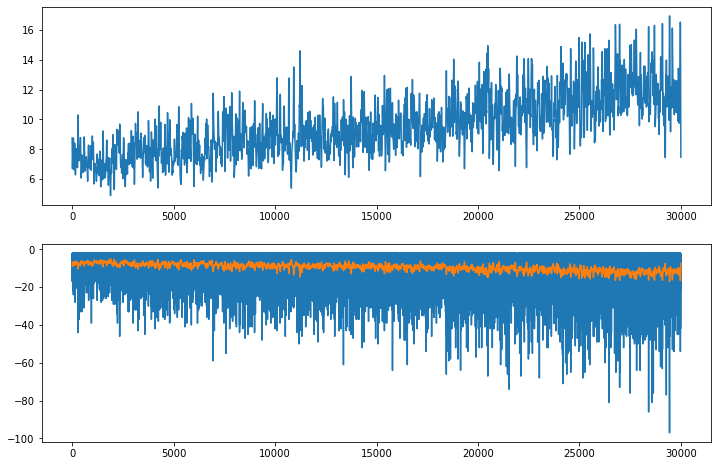

In [190]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(gaussian_filter1d(allt, sigma=10, mode='nearest'))
ax[1].plot(all_totalG)
ax[1].plot(gaussian_filter1d(all_totalG, sigma=10, mode='nearest'))


In [68]:
a_probs = Q_model(amat)


In [146]:
a_probs_np

array([[0.30894938],
       [0.6910506 ]], dtype=float32)

In [145]:
allfoo = []

allfoo = 


print(np.mean(allfoo == 1))

0.69223


In [107]:
a_probs_np.squeeze()

array([0.30894938, 0.6910506 ], dtype=float32)

tensor([[0.3089],
        [0.6911]], grad_fn=<SoftmaxBackward0>)

In [19]:
print(Q_model[0].weight)
print(Q_model[0].weight.grad)
Q_model.zero_grad()
x = torch.tensor([2.0, 1.0], dtype=dtype)
y = Q_model(x)
print(y)
y[0].backward()
print(Q_model[0].weight)
print(Q_model[0].weight.grad)


Parameter containing:
tensor([[-0.0876, -0.3644],
        [-0.0134,  0.3436]], requires_grad=True)
None
tensor([-0.0207, -0.2016], grad_fn=<AddBackward0>)
Parameter containing:
tensor([[-0.0876, -0.3644],
        [-0.0134,  0.3436]], requires_grad=True)
tensor([[2., 1.],
        [0., 0.]])


In [16]:
Q_model[0].weight.grad

tensor([[ 0.2655,  0.1327],
        [-0.2655, -0.1327]])

In [ ]:
dtype = torch.float
w = torch.normal(0.0, 0.001, size=(3, 2), dtype=dtype, requires_grad=True)

torch

# Gradient SARSA(1)

In [62]:
obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()
w = torch.normal(0.0, 0.001, size=(2, 2), dtype=torch.float, requires_grad=True)

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = 0
    terminated = False
    s = env.reset()
    
    with torch.no_grad():
        allq = torch.matmul(w, s)
    a = ag.select_action(allq)

    while (terminated is False) :
        
        allq = torch.matmul(w, s)
        q_now = allq[a, 0]
        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = torch.matmul(w, s_next)
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next, 0]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            w -= alpha * w.grad
            w.grad = None
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 1000, t=12
episode 2000, t=14
episode 3000, t=9
episode 4000, t=11


tensor([[ 10.0566,  -8.9446],
        [  9.2750, -10.5297]], requires_grad=True)


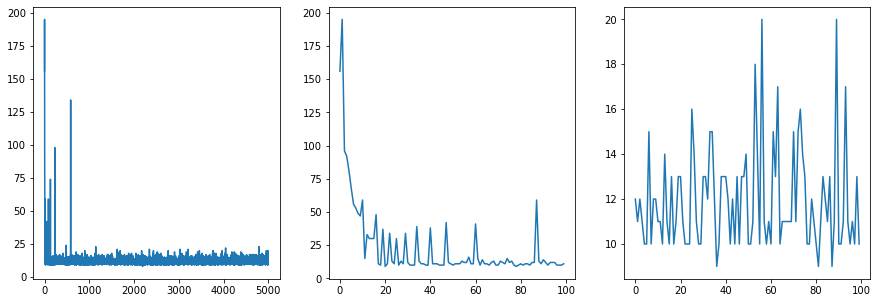

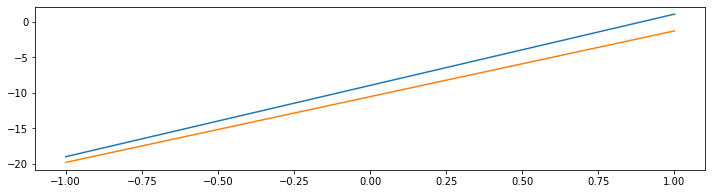

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[-100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = torch.matmul(w, x)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[0, :])
ax.plot(xtmp1, testq[1, :])
print(w)

# Gradient SARSA(1) (nn.sequential)

In [64]:
dtype = torch.float
device = torch.device("cpu")
Q_model = torch.nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)

torch.nn.init.normal_(Q_model[0].weight, 0, 1e-3)
torch.nn.init.normal_(Q_model[2].weight, 0, 1e-3)
print()


In [65]:
obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = 0
    terminated = False
    s = env.reset()
    with torch.no_grad():
        allq = Q_model(s.squeeze())
        a = ag.select_action(allq)

    Q_model.zero_grad()
    
    while (terminated is False) :
        
        allq = Q_model(s.squeeze())
        q_now = allq[a]

        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = Q_model(s_next.squeeze())
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            Q_model[0].weight -= Q_model[0].weight.grad * alpha
            Q_model[2].weight -= Q_model[2].weight.grad * alpha
            Q_model.zero_grad()
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 1000, t=11
episode 2000, t=16
episode 3000, t=15
episode 4000, t=13


Parameter containing:
tensor([[ 2.1876e-04, -4.8863e-04],
        [ 3.0922e-04,  1.9176e-03],
        [-2.1400e-03, -1.0844e-03],
        [-1.3593e-01,  9.5004e-02],
        [-2.8162e+00,  1.9498e+00],
        [ 4.3862e-04, -1.2982e-03],
        [ 6.3266e-04,  7.5325e-04],
        [-3.4240e-04, -1.8084e-05],
        [-1.6015e+00,  1.1088e+00],
        [-2.1497e+00,  1.4936e+00]], requires_grad=True)
Parameter containing:
tensor([[-4.4401e-04,  1.9775e-04, -4.4102e-04, -8.3444e-02, -1.7741e+00,
          9.6276e-04, -1.8207e-03, -6.8342e-04, -1.0641e+00, -1.4211e+00],
        [ 3.2312e-04,  6.9195e-04, -1.2503e-04, -1.1872e-01, -2.3988e+00,
         -3.8578e-04, -3.8278e-04, -7.3892e-04, -1.3096e+00, -1.7752e+00]],
       requires_grad=True)


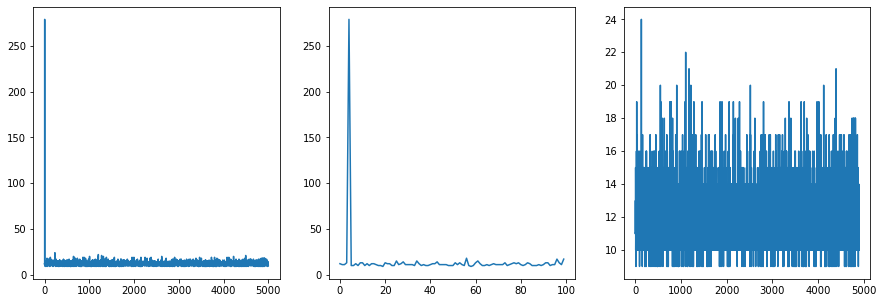

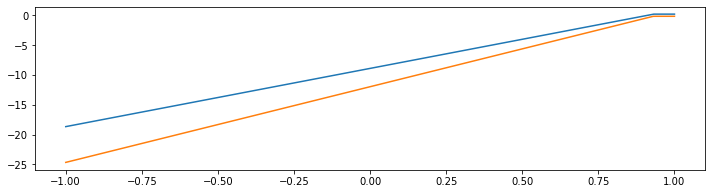

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = Q_model(x.T)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[:, 0])
ax.plot(xtmp1, testq[:, 1])
print(Q_model[0].weight)
print(Q_model[2].weight)

# Gradient Sarsa($\lambda$)

In [73]:
dtype = torch.float
device = torch.device("cpu")
Q_model = torch.nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 2)
)


params = [
    Q_model[0].weight,
    Q_model[0].bias,
    Q_model[2].weight,
    Q_model[2].bias
]

for param in params:
    torch.nn.init.normal_(param, 0, 1e-3)


obs_dim = 2
act_dim = 2
gamma = 0.98
alpha = 0.01
epsilon=0.1
lamb = 0.8

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = RandomWalker1D()
Niters = 1000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 100 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
        # print(Q_model[0].weight, Q_model[2].weight)
    t = 0
    terminated = False
    s = env.reset()
    with torch.no_grad():
        allq = Q_model(s.squeeze())
        a = ag.select_action(allq)

    Q_model.zero_grad()
    z_traces = []
    for param in params:
        z_traces.append(torch.zeros(param.shape, dtype=torch.float))
    

    while (terminated is False) :
        
        allq = Q_model(s.squeeze())
        q_now = allq[a]

        s_next, r_next, terminated = env.step(a)
        with torch.no_grad():
            allq_next = Q_model(s_next.squeeze())
        
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            for parami in range(len(params)):
                z_traces[parami] = gamma * lamb *z_traces[parami] + params[parami].grad
                params[parami] -= z_traces[parami] * alpha



            Q_model.zero_grad()
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 0, t=0
episode 100, t=13
episode 200, t=11
episode 300, t=10
episode 400, t=11
episode 500, t=12
episode 600, t=14
episode 700, t=13
episode 800, t=10
episode 900, t=15


Parameter containing:
tensor([[-3.0719e-04, -7.0003e-04],
        [-1.4084e-04, -1.0618e-03],
        [-2.9249e-01, -2.8950e-02],
        [ 3.1667e-04, -3.7494e-04],
        [ 6.7409e-04, -6.1672e-04],
        [-3.2450e-04, -1.0245e-03],
        [-7.0387e-04,  1.2107e-04],
        [-9.5770e-01, -1.0634e-01],
        [-2.5509e-04,  6.6590e-04],
        [-1.5142e-03, -1.1526e-03],
        [-7.8984e-01,  3.7233e-01],
        [-8.0884e-04, -5.9409e-04],
        [ 5.7128e-04,  3.1136e-06],
        [-1.6659e-03, -2.0082e-04],
        [-1.4920e+00, -1.6393e-01],
        [-1.1941e-03, -1.8045e-03],
        [ 2.4555e-03, -1.7575e-03],
        [-6.0374e-04,  1.6908e-03],
        [-9.3844e-04,  1.4864e-03],
        [ 6.0108e-04, -5.2742e-04],
        [-1.8424e+00,  8.6578e-01],
        [ 9.6494e-04, -3.0893e-04],
        [-6.9031e-04, -4.4911e-04],
        [-6.2298e-04,  2.0285e-04],
        [-9.9301e-04,  3.5851e-05],
        [-9.9462e-04, -6.7843e-04],
        [-6.9104e-01, -7.6827e-02],
      

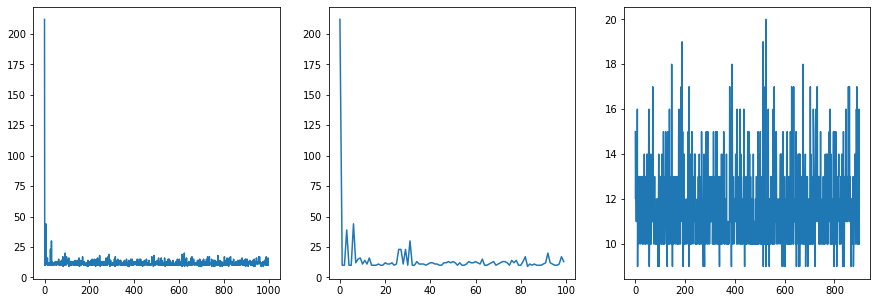

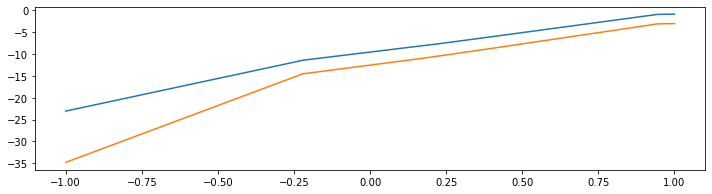

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[100:])


xtmp1 = torch.linspace(-1, 1, 1000, dtype=torch.float)
xtmp2 = torch.ones(1000, dtype=torch.float)
x = torch.stack([xtmp1, xtmp2])
with torch.no_grad():
    testq = Q_model(x.T)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(xtmp1, testq[:, 0])
ax.plot(xtmp1, testq[:, 1])
print(Q_model[0].weight)
print(Q_model[2].weight)